In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os
from netCDF4 import Dataset 

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [2]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## System properties

In [3]:
#In LJ units

#System dimensions
d = 2

#Smoothing length coefficient
h3 = 3.5

#System size
L_x = 10 #Size of the system
L_y = L_x

#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y

#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)

## Functions

In [4]:
#Analytically obtained gradient
def calc_ref_gradient(x,y):
    #gradient = u_0*k_x*np.cos(k_x*x)
    gradient = 0
    return gradient

In [5]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

In [6]:
def calc_divergence(ds):
    atom_values = {}
    frame = -1
    atom_ids = (ds["id"][frame])
    for atom in atom_ids:
        coords = (ds["coordinates"][frame,atom-1,0:2]) #coords
        x = coords[0]
        y = coords[1]
        
        grad_v = (ds["f_rheo_grad_gradv"][frame,atom-1,:])[0] #grad v
        
        atom_values[(x,y)] = grad_v

    return atom_values

In [7]:
#Benchmark by plotting kinetic energy decay and viscosity
def benchmark(data_files):

    fig, ax = plt.subplots(1,1)
    all_run_info = []

    for run in data_files:
        #Read the filepath and create a dataset
        run_info = list(run)[0:2]
        ds = Dataset(data_files[run])
        
        #Scaling variables
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        run_info.append(L_x/sf)
        
        #Calculate divergence from data and error wrt analytical gradient
        atom_values = calc_divergence(ds)
        error = []
        for item in atom_values.items():
            ref_gradient = calc_ref_gradient(item[0][0],item[0][1])
            particle_error = np.abs(ref_gradient-item[1])
            error.append(particle_error)
        L_1_norm = np.sum(error)/len(atom_values)
        run_info.append(L_1_norm)
        
        all_run_info.append(run_info)
    
    #Convert run_info to dataframe for plotting
    df = pd.DataFrame(all_run_info, columns=["Shifting","RK","Resolution","Error"])    
    for i in df["Shifting"].unique():
        df_1 = df[df["Shifting"]==i]
        for j in df_1["RK"].unique():
            df_2 = df_1[df_1["RK"]==j]
            df_2 = df_2.sort_values(by=["Resolution"])
            label = "Shifting: " + i + " (CRK" + j + ")"
            plt.loglog(df_2["Resolution"],df_2["Error"],label=label)
        
        
    plt.legend()
    plt.ylabel(r"$\log{(\frac{L_1}{N})}$")
    plt.xlabel(r"$\log{(\frac{L}{\Delta x})}$")

    
    return df
    

,Shifting,RK,Resolution,Error
0,0,0,200.0,2.698501e-04
1,0,2,200.0,2.044068e-07
2,0,2,100.0,7.728191e-07
3,1,2,20.0,3.370112e-05
4,0,0,100.0,2.496748e-04
5,1,2,2000.0,6.234874e-10
6,1,0,20.0,1.967608e-04
7,1,0,2000.0,8.549040e-05
8,0,0,2000.0,1.821047e-04
9,1,2,100.0,6.505097e-07


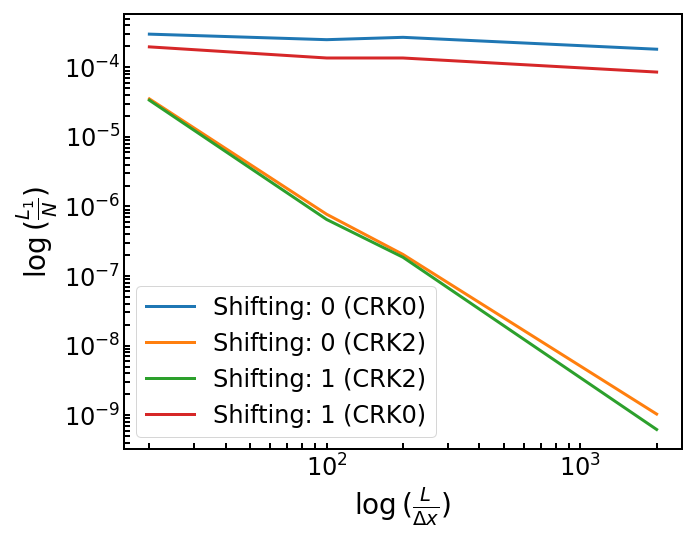

In [8]:
filepath = '/home/epalermo/dev/test/kernel_convergence/gradv_convergence/data_files'
benchmark(generate_file_names(filepath))